In [ ]:
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pathlib
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing import image

# Load data and Preparation

In [ ]:
# Membuat direktori baru
folder_name = 'dataset'
path = '/content/' + folder_name

os.makedirs(path, exist_ok=True)

In [ ]:
# Download data dari repositori GitHub
file_url = 'https://github.com/Whyuuuau/ToothScan/raw/main/Machine%20Learning/dataset.zip'

# Mengirim permintaan GET untuk mengunduh file
r = requests.get(file_url, stream=True)

# Menggabungkan path dengan nama file
file_path = os.path.join(path, 'dataset.zip')

# Menyimpan file ke dalam direktori yang telah dibuat
with open(file_path, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

In [ ]:
# Mengekstrak file zip
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(path)

# Hapus file zip setelah diekstrak
os.remove(file_path)

In [ ]:
base_dir = 'dataset/dataset/teeth_dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['train', 'test']

Contents of train directory:
['Karies', 'Berlubang', 'Sehat']

Contents of validation directory:
['Karies', 'Berlubang', 'Sehat']


In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with training pictures
train_berlubang_dir = os.path.join(train_dir, 'Berlubang')
train_karies_dir = os.path.join(train_dir, 'Karies')
train_sehat_dir = os.path.join(train_dir, 'Sehat')

# Directory with validation pictures
validation_berlubang_dir = os.path.join(validation_dir, 'Berlubang')
validation_karies_dir = os.path.join(validation_dir, 'Karies')
validation_sehat_dir = os.path.join(validation_dir, 'Sehat')

In [ ]:
train_berlubang_fnames = os.listdir(train_berlubang_dir)
train_karies_fnames = os.listdir(train_karies_dir)
train_sehat_fnames = os.listdir(train_sehat_dir)


print(train_berlubang_fnames[:10])
print(train_karies_fnames[:10])
print(train_sehat_fnames[:10])

['wc3.jpg', 'wc37.jpg', 'wc36.jpg', 'wc31.jpg', 'wc21.jpg', 'wc33.jpg', 'wc30.jpg', 'wc2.jpg', 'wc34.jpg', 'wc13.jpg']
['wc19.jpg', 'wc25.jpg', 'wc42.jpg', 'wc18.jpg', 'wc14.jpg', 'wc23.jpg', 'wc41.jpg', 'wc16.jpg', 'wc28.jpg', 'wc10.jpg']
['nc14.jpg', 'nc20.jpeg', 'nc7.jpg', 'nc18.jpg', 'nc19.jpg', 'nc6.jpg', 'nc16.jpg', 'nc22.jpg', 'nc17.jpg', 'nc8.jpg']


In [ ]:
print('total training berlubang images :', len(os.listdir( train_berlubang_dir ) ))
print('total training karies images :', len(os.listdir( train_karies_dir ) ))
print('total training sehat images :', len(os.listdir( train_sehat_dir ) ))

print('total validation berlubang images :', len(os.listdir( validation_berlubang_dir ) ))
print('total validation karies images :', len(os.listdir( validation_karies_dir ) ))
print('total validation sehat images :', len(os.listdir( validation_sehat_dir ) ))

total training berlubang images : 26
total training karies images : 17
total training sehat images : 15
total validation berlubang images : 7
total validation karies images : 5
total validation sehat images : 4


In [ ]:
class_names = ['Karies', 'Berlubang', 'Sehat']

In [ ]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

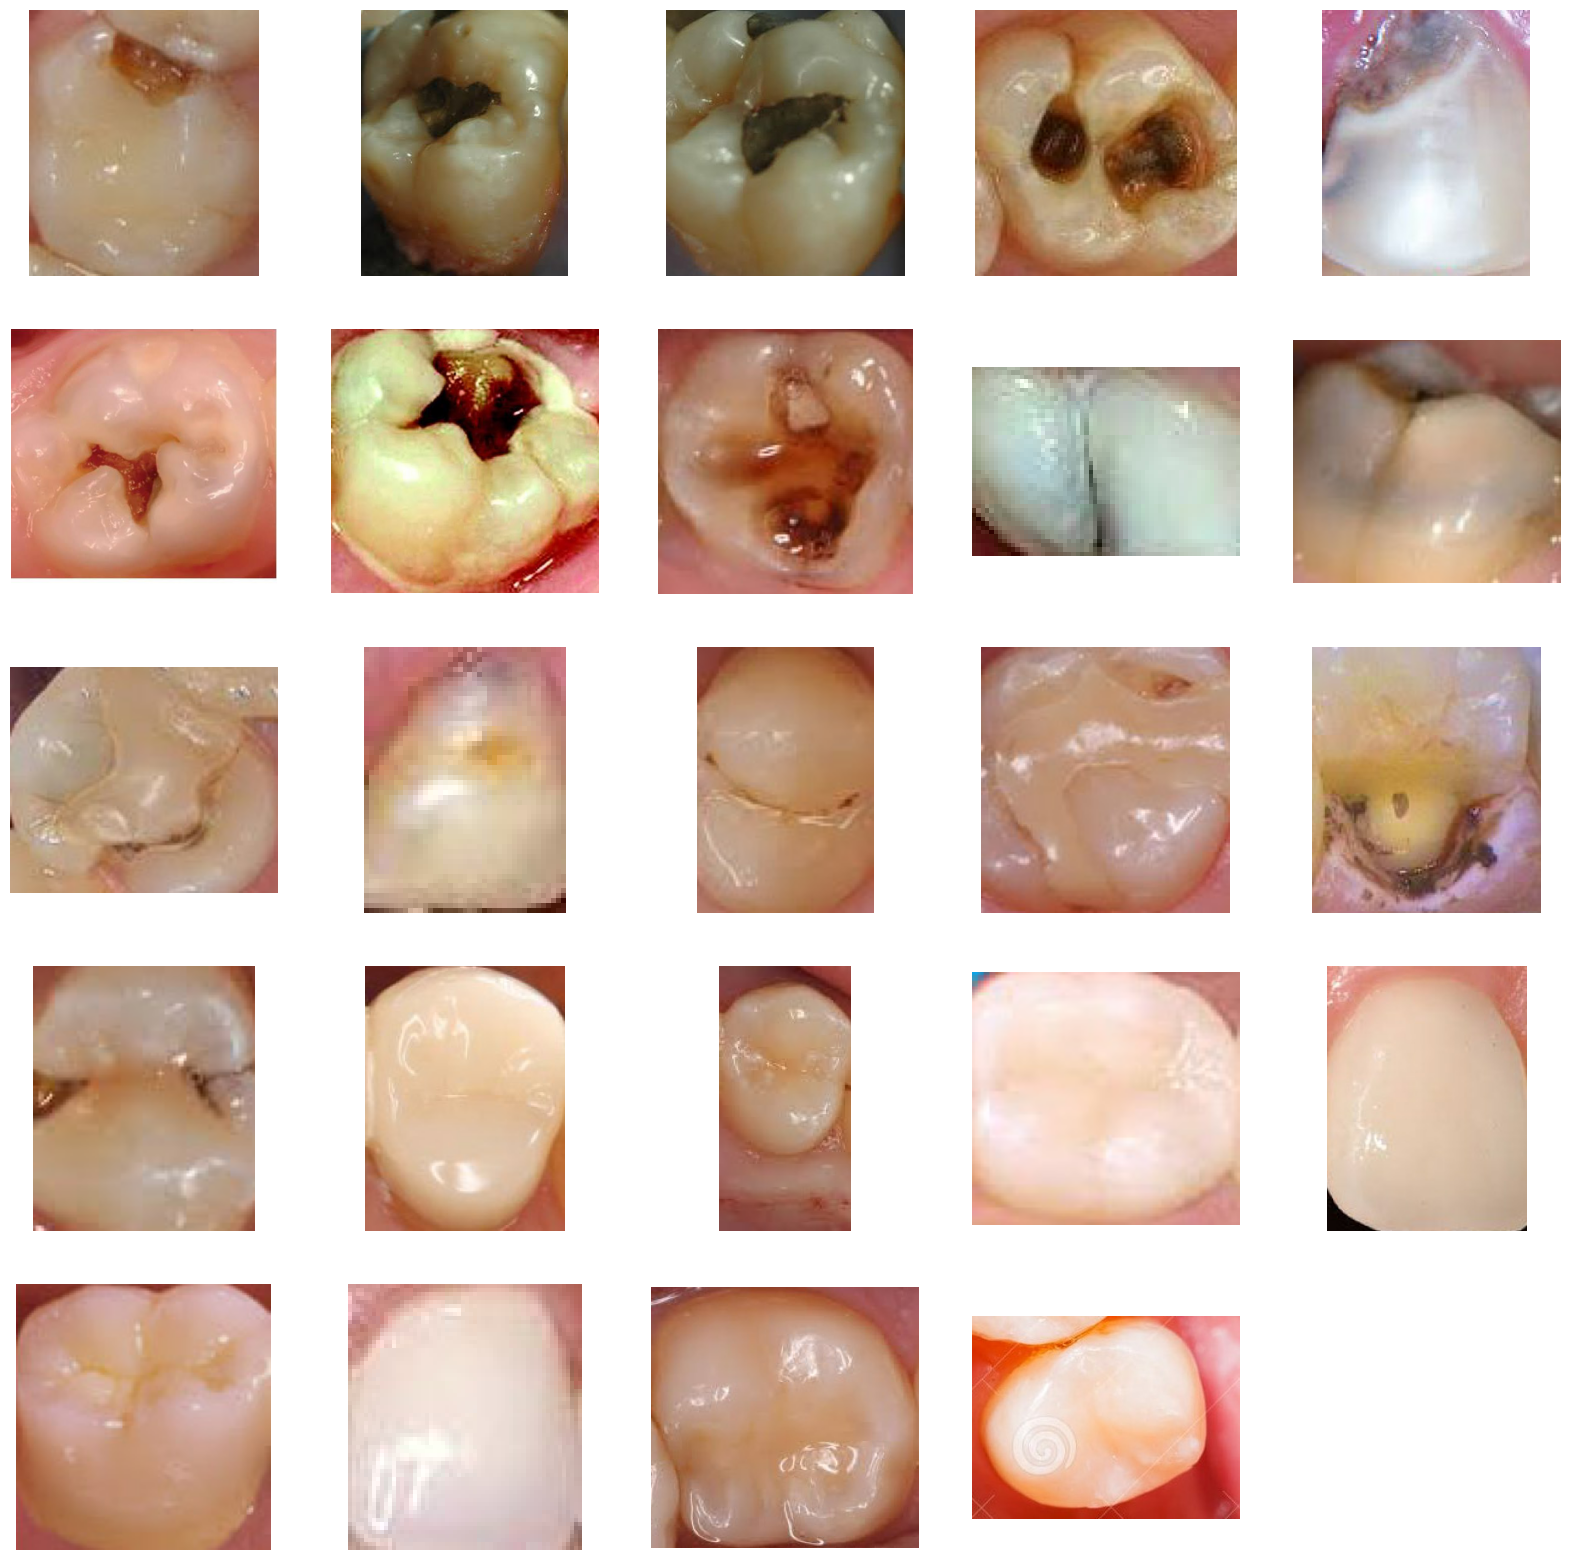

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 5
ncols = 5

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_berlubang_pix = [os.path.join(train_berlubang_dir, fname)
                for fname in train_berlubang_fnames[ pic_index-8:pic_index]
               ]

next_karies_pix = [os.path.join(train_karies_dir, fname)
                for fname in train_karies_fnames[ pic_index-8:pic_index]
               ]

next_sehat_pix = [os.path.join(train_sehat_dir, fname)
                for fname in train_sehat_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_berlubang_pix+next_karies_pix+next_sehat_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Data Augmentation

In [ ]:
# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='sparse')

Found 58 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


In [ ]:
dataset_labels = sorted(validation_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Berlubang' 'Karies' 'Sehat']


# Modeling

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 64 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
#model = tf.keras.models.Sequential([
#      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)),
#      tf.keras.layers.MaxPooling2D(2, 2),

#      tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#      tf.keras.layers.MaxPooling2D(2,2),

#      tf.keras.layers.Flatten(),
#      tf.keras.layers.Dense(512, activation = 'relu'),
#      tf.keras.layers.Dense(256, activation = 'relu'),
#      tf.keras.layers.Dense(128, activation = 'relu'),
#      tf.keras.layers.Dense(26, activation = 'softmax')
#      ])

In [ ]:
model.compile(optimizer = 'Adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator)

Epoch 1/100
3/3 [==============================] - 3s 522ms/step - loss: 1.3862 - accuracy: 0.3793 - val_loss: 1.1062 - val_accuracy: 0.4375
Epoch 2/100
3/3 [==============================] - 1s 403ms/step - loss: 1.0499 - accuracy: 0.4828 - val_loss: 1.0078 - val_accuracy: 0.4375
Epoch 3/100
3/3 [==============================] - 2s 602ms/step - loss: 1.0336 - accuracy: 0.4483 - val_loss: 0.8405 - val_accuracy: 0.6875
Epoch 4/100
3/3 [==============================] - 1s 428ms/step - loss: 1.0033 - accuracy: 0.5172 - val_loss: 0.7608 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 2s 417ms/step - loss: 0.9105 - accuracy: 0.4828 - val_loss: 0.6456 - val_accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 2s 447ms/step - loss: 0.9496 - accuracy: 0.5172 - val_loss: 0.6034 - val_accuracy: 0.8750
Epoch 7/100
3/3 [==============================] - 2s 425ms/step - loss: 0.8883 - accuracy: 0.6034 - val_loss: 0.7737 - val_accuracy: 0.6250
Epoch 8/100
3

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


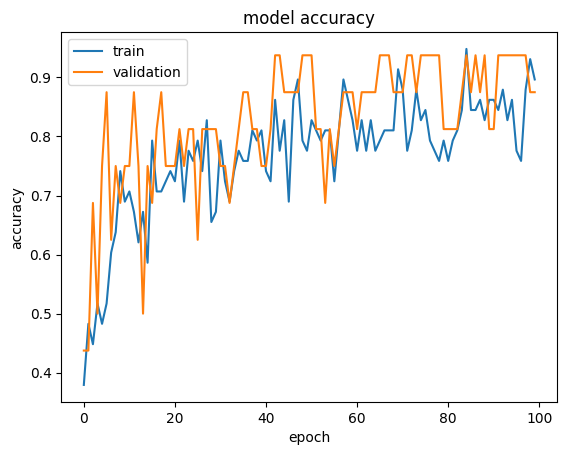

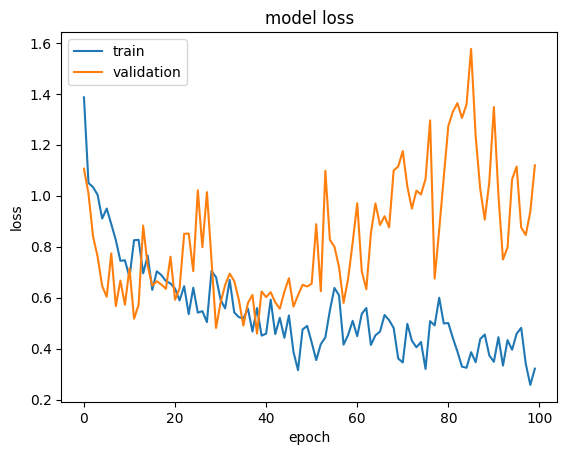

In [ ]:
# "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Export model

In [ ]:
# Use the tf.saved_model API to save your model in the SavedModel format.
export_dir = 'saved_model/model_gigi'

tf.saved_model.save(model,export_dir=export_dir)

In [ ]:
# Load SavedModel
gigi_model = hub.load(export_dir)
print(gigi_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7ebc6578d720>


# Nyoba

In [ ]:
model = tf.keras.models.load_model(saved_model_path)

ValueError: ignored

In [ ]:
# Fungsi untuk memprediksi gambar baru
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan dengan ukuran yang digunakan saat pelatihan
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    processed_img = preprocess_input(img_array)  # Sesuaikan dengan fungsi preprocessing yang digunakan saat pelatihan

    # Prediksi kelas gambar
    predictions = model.predict(processed_img)
    return predictions

In [ ]:
# Path ke gambar baru yang ingin diprediksi
new_image_path = 'coba1.jpeg'

# Lakukan prediksi
predictions = predict_image(gigi_model, 'coba1.jpeg')

# Proses hasil prediksi
predicted_class = np.argmax(predictions, axis=1)  # Ambil kelas dengan probabilitas tertinggi
# Misalnya, jika ada label untuk kelas, kamu dapat menambahkan logika ini:
# predicted_label = labels[predicted_class[0]]

# Tampilkan hasil prediksi
print("Hasil Prediksi:", predicted_class)

NameError: ignored

## Check Predictions on loaded model

In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

# Validation batch shape tells us that we have a batch of 16 images, with size and channels: 150x150x3.

Validation batch shape: (16, 150, 150, 3)


In [ ]:
tf_model_predictions = gigi_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (16, 3)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tf_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tflite_pred_dataframe.head()

Prediction results for the first elements


,Berlubang,Karies,Sehat
0,0.281529,0.718446,2.454919e-05
1,0.069280,0.698524,2.321964e-01
2,0.027811,0.145518,8.266710e-01
3,0.186017,0.812327,1.655794e-03
4,0.999982,0.000018,9.341187e-14


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

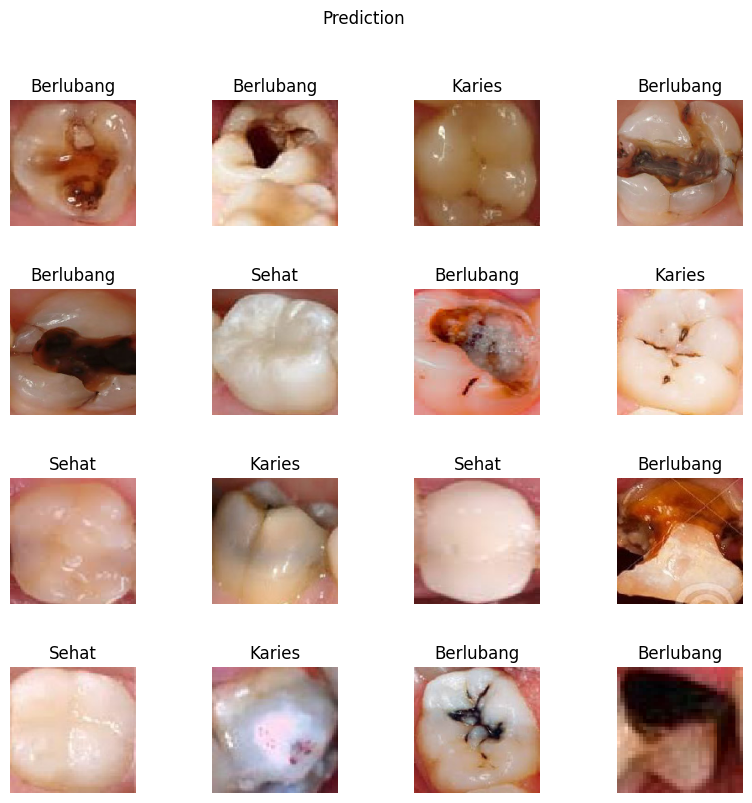

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tf_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(16):
  plt.subplot(4,4,n+1)
  plt.imshow(val_image_batch[n])
  plt.title(tflite_predicted_labels[n].title())
  plt.axis('off')
_ = plt.suptitle("Prediction")

## Convert model to TFLite

In [ ]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [ ]:
tflite_model_file = pathlib.Path('./model_gigi.tflite')
tflite_model_file.write_bytes(tflite_model)

1215344